In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV3
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root' 
data_file = uproot.open(data_path)
LC_x = data_file['clusters']['position_x'].array()
pgid = data_file['simtrackstersCP']['pdgID'].array()
skim_mask = []
for e in LC_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
pgid = pgid[skim_mask]


In [10]:
import pandas as pd

df_GAT = pd.read_csv("csvMix/df_GAT_Mix_017.csv")
df_DE = pd.read_csv("csvMix/df_DE_mix_0175.csv")
df_Trans = pd.read_csv("csvMix/df_Trans_Mix_016.csv")
df_Track = pd.read_csv("csvMix/df_TICL_track.csv")
df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

df_GAT_e = pd.read_csv("csvPion/df_GAT_pi_017.csv")
df_DE_e = pd.read_csv("csvPion/df_DE_pi_0175.csv")
df_Trans_e = pd.read_csv("csvPion/df_Trans_pi_016.csv")
df_Track_e = pd.read_csv("csvPion/df_TICL_Track_pion.csv")
df_MT_e = pd.read_csv("csvPion/df_TICL_MT_pion.csv")




In [11]:
df_GAT['pgid'] = df_GAT.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_DE['pgid'] = df_DE.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_Trans['pgid'] = df_Trans.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_Track['pgid'] = df_Track.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_MT['pgid'] = df_MT.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)


/tmp/ipykernel_738044/2529864306.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_738044/2529864306.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_738044/2529864306.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

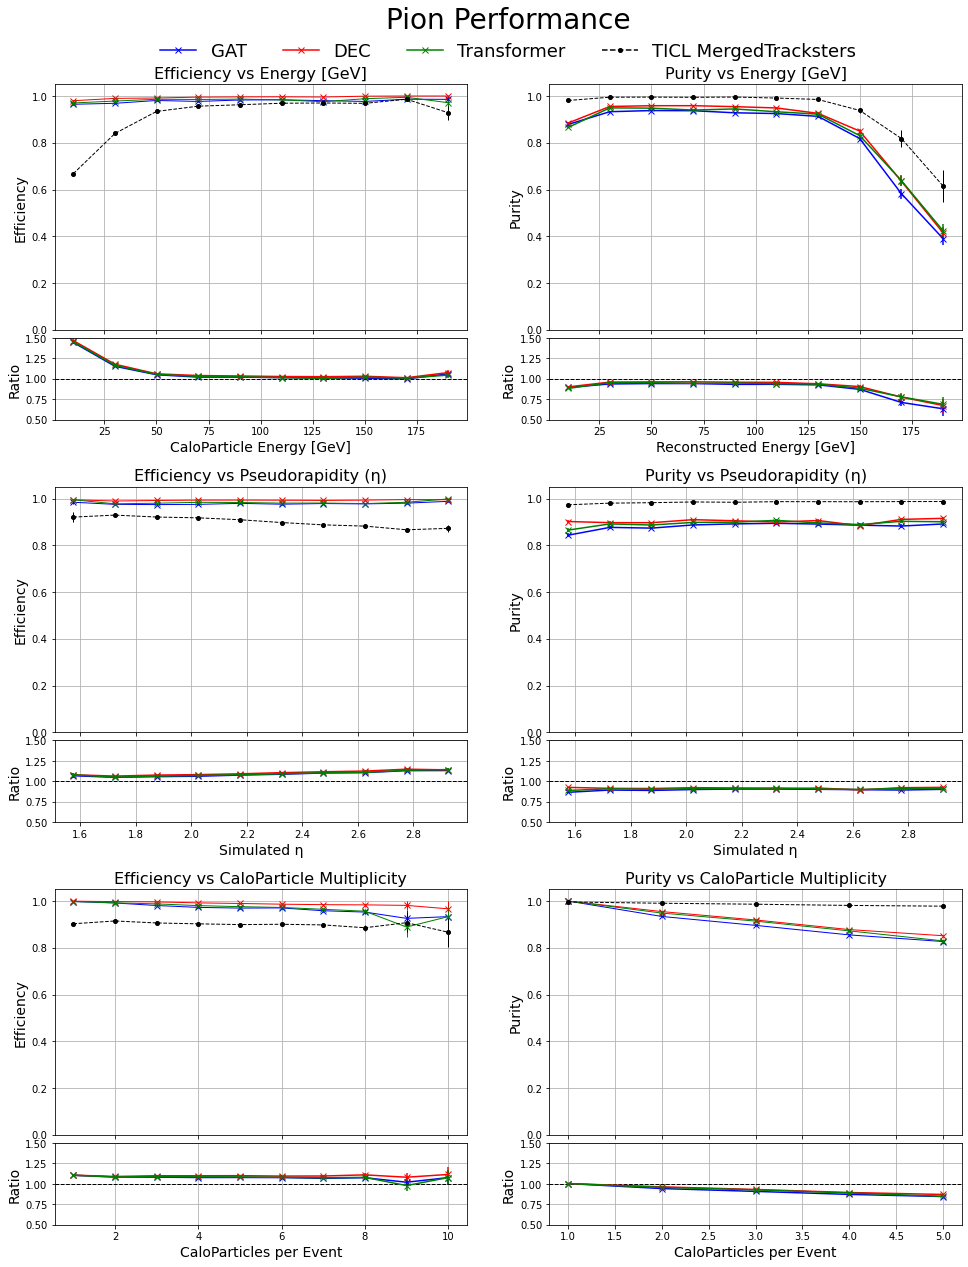

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

###############################################################################
# 1. ENERGY-BASED DATA PREPARATION
###############################################################################
# Efficiency from CaloParticle data (dropping "CERN Tracksters")
model_dfs_all_energy = {
    "GAT": df_GAT,
    "DE": df_DE,   # will be renamed to "DEC"
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,   # to be dropped
    "CERN Mixed Tracksters": df_MT
}
for name, df in model_dfs_all_energy.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    model_dfs_all_energy[name] = df[df['pgid'].isin([211, -211])]

def prepare_cp_data_energy(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

model_prepared_all_energy = {name: prepare_cp_data_energy(df)
                             for name, df in model_dfs_all_energy.items()}

# Energy binning
all_energies = pd.concat([df['cp_energy'] for df in model_prepared_all_energy.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

for df in model_prepared_all_energy.values():
    df['energy_bin'] = pd.cut(df['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

def aggregate_efficiency(df):
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_energy = {name: aggregate_efficiency(df) for name, df in model_prepared_all_energy.items()}

# Final efficiency dictionary (drop "CERN Tracksters" and rename "DE" to "DEC")
model_efficiency = {
    "GAT": eff_all_energy["GAT"],
    "DEC": eff_all_energy["DE"],
    "Transformer": eff_all_energy["Transformer"],
    "TICL MergedTracksters": eff_all_energy["CERN Mixed Tracksters"]
}

# Purity from electron (trackster) data (energy version)
model_dfs_e_all_energy = {
    'GAT': df_GAT_e,
    'DE': df_DE_e,   # will become "DEC"
    'Transformer': df_Trans_e,
    'CERN Tracksters': df_Track_e,  # dropped
    'CERN Mixed Tracksters': df_MT_e
}

def prepare_trackster_data_energy(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

prepared_dfs_e_all_energy = {name: prepare_trackster_data_energy(df)
                             for name, df in model_dfs_e_all_energy.items()}

# Use the same energy binning for tracksters
all_energies_e = pd.concat([df['trackster_energy'] for df in prepared_dfs_e_all_energy.values()])
min_energy_e = all_energies_e.min()
max_energy_e = 200
energy_bins_e = np.linspace(min_energy_e, max_energy_e, n_bins + 1)
bin_centers_e = 0.5 * (energy_bins_e[:-1] + energy_bins_e[1:])

for df in prepared_dfs_e_all_energy.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins_e, labels=False, include_lowest=True)

def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_energy = {name: aggregate_purity(df) for name, df in prepared_dfs_e_all_energy.items()}

model_purity = {
    "GAT": pur_all_energy["GAT"],
    "DEC": pur_all_energy["DE"],
    "Transformer": pur_all_energy["Transformer"],
    "TICL MergedTracksters": pur_all_energy["CERN Mixed Tracksters"]
}

###############################################################################
# 2. ETA-BASED DATA PREPARATION
###############################################################################
# Efficiency vs. η from CaloParticle data
model_dfs_all_eta = {
    "GAT": df_GAT,
    "DE": df_DE,    # will be renamed to "DEC"
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,  # dropped
    "CERN Mixed Tracksters": df_MT
}
for name, df in model_dfs_all_eta.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    model_dfs_all_eta[name] = df[df['pgid'].isin([211, -211])]

def prepare_cp_data_eta(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'cp_eta': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

model_prepared_all_eta = {name: prepare_cp_data_eta(df) for name, df in model_dfs_all_eta.items()}

# η binning: from 1.5 to 3.0 in 10 bins
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2

for df in model_prepared_all_eta.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

def aggregate_efficiency_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_eta = {name: aggregate_efficiency_eta(df) for name, df in model_prepared_all_eta.items()}

model_efficiency_eta = {
    "GAT": eff_all_eta["GAT"],
    "DEC": eff_all_eta["DE"],
    "Transformer": eff_all_eta["Transformer"],
    "TICL MergedTracksters": eff_all_eta["CERN Mixed Tracksters"]
}

# Purity vs. η from electron trackster data
model_dfs_e_all_eta = {
    "GAT": df_GAT_e,
    "DE": df_DE_e,   # becomes "DEC"
    "Transformer": df_Trans_e,
    "CERN Tracksters": df_Track_e,  # dropped
    "CERN Mixed Tracksters": df_MT_e
}

def prepare_trackster_data_eta(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')  # assuming exists
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_eta = {name: prepare_trackster_data_eta(df) for name, df in model_dfs_e_all_eta.items()}

for df in model_prepared_e_eta.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_eta = {name: aggregate_purity_eta(df) for name, df in model_prepared_e_eta.items()}

model_purity_eta = {
    "GAT": pur_all_eta["GAT"],
    "DEC": pur_all_eta["DE"],
    "Transformer": pur_all_eta["Transformer"],
    "TICL MergedTracksters": pur_all_eta["CERN Mixed Tracksters"]
}

###############################################################################
# 3. nCP-BASED DATA PREPARATION
###############################################################################
# Efficiency vs. CaloParticle Multiplicity
model_dfs_all_ncp = {
    "GAT": df_GAT,
    "DE": df_DE,    # becomes "DEC"
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,  # dropped later
    "CERN Mixed Tracksters": df_MT
}
for name, df in model_dfs_all_ncp.items():
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df = df[df['pgid'].isin([211, -211])]
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max',
        'n_cp': 'first'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    model_dfs_all_ncp[name] = grouped

def aggregate_efficiency_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_cp=('cp_id', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all_ncp = {name: aggregate_efficiency_ncp(df) for name, df in model_dfs_all_ncp.items()}

model_efficiency_ncp = {
    "GAT": eff_all_ncp["GAT"],
    "DEC": eff_all_ncp["DE"],
    "Transformer": eff_all_ncp["Transformer"],
    "TICL MergedTracksters": eff_all_ncp["CERN Mixed Tracksters"]
}

# Purity vs. CaloParticle Multiplicity from electron trackster data
model_dfs_e_all_ncp = {
    "GAT": df_GAT_e,
    "DE": df_DE_e,   # becomes "DEC"
    "Transformer": df_Trans_e,
    "CERN Tracksters": df_Track_e,  # dropped
    "CERN Mixed Tracksters": df_MT_e
}

def prepare_trackster_data_ncp(df):
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'reco_to_sim_score': 'min',
        'n_cp': 'first'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_ncp = {name: prepare_trackster_data_ncp(df) for name, df in model_dfs_e_all_ncp.items()}

def aggregate_purity_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_ts=('trackster_id', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_ncp = {name: aggregate_purity_ncp(df) for name, df in model_prepared_e_ncp.items()}

model_purity_ncp = {
    "GAT": pur_all_ncp["GAT"],
    "DEC": pur_all_ncp["DE"],
    "Transformer": pur_all_ncp["Transformer"],
    "TICL MergedTracksters": pur_all_ncp["CERN Mixed Tracksters"]
}

###############################################################################
# 4. COMBINED PLOTTING
###############################################################################
# Color mappings for each set
eff_colors_energy = {"GAT": "blue", "DEC": "red", "Transformer": "green",
                     "TICL MergedTracksters": "black"}
pur_colors_energy = eff_colors_energy.copy()

eff_colors_eta = {"GAT": "blue", "DEC": "red", "Transformer": "green",
                  "TICL MergedTracksters": "black"}
pur_colors_eta = eff_colors_eta.copy()

eff_colors_ncp = {"GAT": "blue", "DEC": "red", "Transformer": "green",
                  "TICL MergedTracksters": "black"}
pur_colors_ncp = eff_colors_ncp.copy()

# Create the outer figure with 3 rows (for Energy, η, and Multiplicity) and 2 columns (Efficiency, Purity)
fig = plt.figure(figsize=(14, 18))
outer_gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.2, wspace=0.2)

#### Row 0: Energy-Based Plots ####
# Left: Efficiency vs. Energy with ratio subplot
gs0_left = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.05)
ax0_eff = fig.add_subplot(gs0_left[0])
ax0_eff_ratio = fig.add_subplot(gs0_left[1], sharex=ax0_eff)
for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_energy[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_energy[key]; lw = 1; ms = 6
    ax0_eff.errorbar(bin_centers, agg['efficiency'], yerr=agg['eff_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax0_eff.set_title("Efficiency vs Energy [GeV]", fontsize=16)  # was 18, now 16
ax0_eff.set_ylabel('Efficiency', fontsize=14)                  # was 16, now 14
ax0_eff.set_ylim(0, 1.05)
ax0_eff.grid(True)
ax0_eff.tick_params(labelbottom=False)

ref_eff = model_efficiency["TICL MergedTracksters"]
ref_val = ref_eff['efficiency'].replace(0, np.nan)
ref_err = ref_eff['eff_error']
for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['efficiency'] / ref_val
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 +
                                (ref_err/ref_val)**2)
    ax0_eff_ratio.errorbar(bin_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_energy[key])
ax0_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax0_eff_ratio.set_xlabel('CaloParticle Energy [GeV]', fontsize=14)  # was 16
ax0_eff_ratio.set_ylabel('Ratio', fontsize=14)                       # was 16
ax0_eff_ratio.set_ylim(0.5, 1.5)
ax0_eff_ratio.grid(True)

# Right: Purity vs. Energy
gs0_right = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax0_pur = fig.add_subplot(gs0_right[0])
ax0_pur_ratio = fig.add_subplot(gs0_right[1], sharex=ax0_pur)
for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_energy[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_energy[key]; lw = 1.5; ms = 6
    ax0_pur.errorbar(bin_centers_e, agg['purity'], yerr=agg['purity_error'],
                     marker=marker, linestyle=ls, linewidth=lw, markersize=ms, color=color)
ax0_pur.set_title("Purity vs Energy [GeV]", fontsize=16)           # was 18
ax0_pur.set_ylabel('Purity', fontsize=14)                            # was 16
ax0_pur.set_ylim(0, 1.05)
ax0_pur.grid(True)
ax0_pur.tick_params(labelbottom=False)
ref_pur = model_purity["TICL MergedTracksters"]
ref_val_pur = ref_pur['purity'].replace(0, np.nan)
ref_err_pur = ref_pur['purity_error']
for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['purity'] / ref_val_pur
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 +
                                (ref_err_pur/ref_val_pur)**2)
    ax0_pur_ratio.errorbar(bin_centers_e, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_energy[key])
ax0_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax0_pur_ratio.set_xlabel('Reconstructed Energy [GeV]', fontsize=14)  # was 16
ax0_pur_ratio.set_ylabel('Ratio', fontsize=14)                        # was 16
ax0_pur_ratio.set_ylim(0.5, 1.5)
ax0_pur_ratio.grid(True)

#### Row 1: η-Based Plots ####
# Left: Efficiency vs. Pseudorapidity (η)
gs1_left = outer_gs[1, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax1_eff = fig.add_subplot(gs1_left[0])
ax1_eff_ratio = fig.add_subplot(gs1_left[1], sharex=ax1_eff)
for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_eta[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_eta[key]; lw = 1; ms = 6
    ax1_eff.errorbar(eta_centers, agg['efficiency'], yerr=agg['eff_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax1_eff.set_title("Efficiency vs Pseudorapidity (η)", fontsize=16)  # was 18
ax1_eff.set_ylabel('Efficiency', fontsize=14)                         # was 16
ax1_eff.set_ylim(0, 1.05)
ax1_eff.grid(True)
ax1_eff.tick_params(labelbottom=False)

ref_eff_eta = model_efficiency_eta["TICL MergedTracksters"]
ref_val_eta = ref_eff_eta['efficiency'].replace(0, np.nan)
ref_err_eta = ref_eff_eta['eff_error']
for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['efficiency'] / ref_val_eta
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 +
                                (ref_err_eta/ref_val_eta)**2)
    ax1_eff_ratio.errorbar(eta_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_eta[key])
ax1_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax1_eff_ratio.set_xlabel('Simulated η', fontsize=14)                 # was 16
ax1_eff_ratio.set_ylabel('Ratio', fontsize=14)                         # was 16
ax1_eff_ratio.set_ylim(0.5, 1.5)
ax1_eff_ratio.grid(True)

# Right: Purity vs. Pseudorapidity (η)
gs1_right = outer_gs[1, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax1_pur = fig.add_subplot(gs1_right[0])
ax1_pur_ratio = fig.add_subplot(gs1_right[1], sharex=ax1_pur)
for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_eta[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_eta[key]; lw = 1.5; ms = 6
    ax1_pur.errorbar(eta_centers, agg['purity'], yerr=agg['purity_error'],
                     marker=marker, linestyle=ls, linewidth=lw,
                     markersize=ms, color=color)
ax1_pur.set_title("Purity vs Pseudorapidity (η)", fontsize=16)        # was 18
ax1_pur.set_ylabel('Purity', fontsize=14)                              # was 16
ax1_pur.set_ylim(0, 1.05)
ax1_pur.grid(True)
ax1_pur.tick_params(labelbottom=False)
ref_pur_eta = model_purity_eta["TICL MergedTracksters"]
ref_val_p_eta = ref_pur_eta['purity'].replace(0, np.nan)
ref_err_p_eta = ref_pur_eta['purity_error']
for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        continue
    ratio = agg['purity'] / ref_val_p_eta
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 +
                                (ref_err_p_eta/ref_val_p_eta)**2)
    ax1_pur_ratio.errorbar(eta_centers, ratio, yerr=ratio_err,
                           marker="x", linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_eta[key])
ax1_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax1_pur_ratio.set_xlabel('Simulated η', fontsize=14)                  # was 16
ax1_pur_ratio.set_ylabel('Ratio', fontsize=14)                         # was 16
ax1_pur_ratio.set_ylim(0.5, 1.5)
ax1_pur_ratio.grid(True)

#### Row 2: nCP-Based Plots ####
# Left: Efficiency vs. CaloParticle Multiplicity
gs2_left = outer_gs[2, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax2_eff = fig.add_subplot(gs2_left[0])
ax2_eff_ratio = fig.add_subplot(gs2_left[1], sharex=ax2_eff)
for key, df_agg in model_efficiency_ncp.items():
    df_sorted = df_agg.sort_values('n_cp')
    xvals = df_sorted['n_cp']
    yvals = df_sorted['efficiency']
    yerr  = df_sorted['eff_error']
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = eff_colors_ncp[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = eff_colors_ncp[key]; lw = 1; ms = 6
    ax2_eff.errorbar(xvals, yvals, yerr=yerr, marker=marker, linestyle=ls,
                     linewidth=lw, markersize=ms, color=color)
ax2_eff.set_title("Efficiency vs CaloParticle Multiplicity", fontsize=16)  # was 18
ax2_eff.set_ylabel('Efficiency', fontsize=14)                                # was 16
ax2_eff.set_ylim(0, 1.05)
ax2_eff.grid(True)
ax2_eff.tick_params(labelbottom=False)

ref_df_eff = model_efficiency_ncp["TICL MergedTracksters"].sort_values('n_cp')
for key, df_agg in model_efficiency_ncp.items():
    if key == "TICL MergedTracksters":
        continue
    df_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_sorted, ref_df_eff, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['efficiency']
    num_err  = merged['eff_error']
    den_val  = merged['efficiency_ref'].replace(0, np.nan)
    den_err  = merged['eff_error_ref']
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    ax2_eff_ratio.errorbar(xvals, ratio, yerr=ratio_err, marker="x",
                           linestyle="-", linewidth=1.5, markersize=6,
                           color=eff_colors_ncp[key])
ax2_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2_eff_ratio.set_xlabel('CaloParticles per Event', fontsize=14)           # was 16
ax2_eff_ratio.set_ylabel('Ratio', fontsize=14)                              # was 16
ax2_eff_ratio.set_ylim(0.5, 1.5)
ax2_eff_ratio.grid(True)

# Right: Purity vs. CaloParticle Multiplicity
gs2_right = outer_gs[2, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.05)
ax2_pur = fig.add_subplot(gs2_right[0])
ax2_pur_ratio = fig.add_subplot(gs2_right[1], sharex=ax2_pur)
for key, df_agg in model_purity_ncp.items():
    df_sorted = df_agg.sort_values('n_cp')
    xvals = df_sorted['n_cp']
    yvals = df_sorted['purity']
    yerr  = df_sorted['purity_error']
    if key == "TICL MergedTracksters":
        marker = "o"; ls = "--"; color = pur_colors_ncp[key]; lw = 1; ms = 4
    else:
        marker = "x"; ls = "-"; color = pur_colors_ncp[key]; lw = 1; ms = 6
    ax2_pur.errorbar(xvals, yvals, yerr=yerr, marker=marker, linestyle=ls,
                     linewidth=lw, markersize=ms, color=color)
ax2_pur.set_title("Purity vs CaloParticle Multiplicity", fontsize=16)       # was 18
ax2_pur.set_ylabel('Purity', fontsize=14)                                    # was 16
ax2_pur.set_ylim(0, 1.05)
ax2_pur.grid(True)
ax2_pur.tick_params(labelbottom=False)
ref_df_pur = model_purity_ncp["TICL MergedTracksters"].sort_values('n_cp')
for key, df_agg in model_purity_ncp.items():
    if key == "TICL MergedTracksters":
        continue
    df_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_sorted, ref_df_pur, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['purity']
    num_err  = merged['purity_error']
    den_val  = merged['purity_ref'].replace(0, np.nan)
    den_err  = merged['purity_error_ref']
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    ax2_pur_ratio.errorbar(xvals, ratio, yerr=ratio_err, marker="x",
                           linestyle="-", linewidth=1.5, markersize=6,
                           color=pur_colors_ncp[key])
ax2_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2_pur_ratio.set_xlabel('CaloParticles per Event', fontsize=14)           # was 16
ax2_pur_ratio.set_ylabel('Ratio', fontsize=14)                              # was 16
ax2_pur_ratio.set_ylim(0.5, 1.5)
ax2_pur_ratio.grid(True)

###############################################################################
# 5. GLOBAL TITLE, LEGEND, AND FINAL LAYOUT ADJUSTMENTS
###############################################################################
# Overall global title
fig.suptitle("Pion Performance", fontsize=28, y=0.99)

# Global legend using custom line objects with bigger font and no vertical gap
legend_elements = [
    Line2D([0], [0], marker="x", color="blue", linestyle="-", markersize=6, label="GAT"),
    Line2D([0], [0], marker="x", color="red", linestyle="-", markersize=6, label="DEC"),
    Line2D([0], [0], marker="x", color="green", linestyle="-", markersize=6, label="Transformer"),
    Line2D([0], [0], marker="o", color="black", linestyle="--", markersize=4, label="TICL MergedTracksters")
]
# bbox_to_anchor is now set to (0.5, 0.92) to remove vertical gap between legend and top row of subplots
fig.legend(handles=legend_elements, loc="upper center", ncol=4, frameon=False, fontsize=18, bbox_to_anchor=(0.5, 0.975))

# Adjust subplots to maximize available space
fig.subplots_adjust(top=0.93, bottom=0.05, left=0.05, right=0.95)
plt.savefig("PionPerfomance.pdf")
plt.show()


In [11]:
def compute_ratios(metric_dict, reference_key="TICL MergedTracksters", value_col="efficiency", error_col="eff_error", x_label="x"):
    ratios = {}
    ref = metric_dict[reference_key].copy()
    ref_val = ref[value_col].replace(0, np.nan)
    ref_err = ref[error_col]
    ref_x = ref[x_label] if x_label in ref else ref.index

    for key, df in metric_dict.items():
        if key == reference_key:
            continue
        df = df.copy()
        if x_label in df:
            merged = pd.merge(df, ref[[x_label, value_col, error_col]],
                              on=x_label, suffixes=('', '_ref'))
            xvals = merged[x_label]
            num_val = merged[value_col]
            num_err = merged[error_col]
            den_val = merged[f"{value_col}_ref"].replace(0, np.nan)
            den_err = merged[f"{error_col}_ref"]
        else:
            xvals = df.index
            num_val = df[value_col]
            num_err = df[error_col]
            den_val = ref_val
            den_err = ref_err

        ratio = num_val / den_val
        ratio_err = ratio * np.sqrt((num_err / num_val)**2 + (den_err / den_val)**2)

        ratios[key] = pd.DataFrame({
            x_label: xvals,
            'ratio': ratio,
            'ratio_err': ratio_err
        })

    return ratios

# Add bin centers to the corresponding DataFrames for clarity
for df in model_efficiency.values():
    df['energy_bin_center'] = bin_centers[df['energy_bin'].fillna(0).astype(int)]
for df in model_purity.values():
    df['energy_bin_center'] = bin_centers_e[df['energy_bin'].fillna(0).astype(int)]
for df in model_efficiency_eta.values():
    df['eta_bin_center'] = eta_centers[df['eta_bin'].fillna(0).astype(int)]
for df in model_purity_eta.values():
    df['eta_bin_center'] = eta_centers[df['eta_bin'].fillna(0).astype(int)]

# Compute ratios
ratios_all = {
    "Efficiency vs Energy": compute_ratios(model_efficiency, x_label='energy_bin_center'),
    "Purity vs Energy": compute_ratios(model_purity, value_col="purity", error_col="purity_error", x_label='energy_bin_center'),
    "Efficiency vs Eta": compute_ratios(model_efficiency_eta, x_label='eta_bin_center'),
    "Purity vs Eta": compute_ratios(model_purity_eta, value_col="purity", error_col="purity_error", x_label='eta_bin_center'),
    "Efficiency vs nCP": compute_ratios(model_efficiency_ncp, x_label='n_cp'),
    "Purity vs nCP": compute_ratios(model_purity_ncp, value_col="purity", error_col="purity_error", x_label='n_cp')
}

# Print output
for plot_title, model_dict in ratios_all.items():
    print(f"\n=== {plot_title} ===")
    for model_name, df_ratios in model_dict.items():
        print(f"\n{model_name} Ratios:")
        print(df_ratios.to_string(index=False))



=== Efficiency vs Energy ===

GAT Ratios:
 energy_bin_center    ratio  ratio_err
         10.109383 1.444938   0.017714
         30.097869 1.153551   0.008568
         50.086355 1.050041   0.005062
         70.074841 1.021182   0.004385
         90.063327 1.021139   0.003990
        110.051813 1.015090   0.003747
        130.040299 1.010249   0.004155
        150.028785 1.008457   0.006245
        170.017271 1.000000   0.008748
        190.005757 1.061538   0.038362

DEC Ratios:
 energy_bin_center    ratio  ratio_err
         10.109383 1.467633   0.017721
         30.097869 1.178603   0.008312
         50.086355 1.061377   0.004797
         70.074841 1.040412   0.003808
         90.063327 1.034949   0.003523
        110.051813 1.028431   0.003240
        130.040299 1.026307   0.003499
        150.028785 1.031712   0.004904
        170.017271 1.013928   0.006272
        190.005757 1.076923   0.035700

Transformer Ratios:
 energy_bin_center    ratio  ratio_err
         10.109383 1.45334

In [11]:
def calculate_metrics(df, model_name):
    import numpy as np
    #df = df[df['pgid'] == 11].copy()
    # ----- Efficiency Calculation -----
    # Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()
    
    # Define the function to check if a CaloParticle (CP) is associated based on shared energy.
    def is_cp_associated(group):
        cp_energy = group['cp_raw_energy'].iloc[0]  # Assumes cp_raw_energy is consistent in the group.
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()
    
    # Group over event_index and cp_id to determine association for each CP.
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped.apply(is_cp_associated)
    
    # Global efficiency values computed over all events/CPs.
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    overall_efficiency = num_associated_cp / total_cp if total_cp > 0 else 0
    
    # --- Per-Event Efficiency Calculation for Standard Deviation ---
    def event_efficiency(event_df):
        # Group by cp_id for the current event.
        cp_grouped_event = event_df.groupby('cp_id')
        associated = cp_grouped_event.apply(is_cp_associated)
        return associated.mean()  # Fraction of CPs associated in this event.
    
    # Compute a Series of efficiency values indexed by event_index.
    event_eff_series = cp_valid.groupby('event_index').apply(event_efficiency)
    efficiency_std = event_eff_series.std()
    
    # ----- Purity Calculation -----
    # Filter out rows where 'trackster_id' is NaN.
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    
    # Group over event_index and trackster_id and consider a Trackster "associated"
    # if its minimum reco_to_sim_score across CPs is below 0.2.
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    overall_purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
    # --- Per-Event Purity Calculation for Standard Deviation ---
    def event_purity(event_df):
        # Within the event, group by trackster_id and check if associated.
        trackster_grouped_event = event_df.groupby('trackster_id')
        purity_series = trackster_grouped_event['reco_to_sim_score'].min() < 0.2
        return purity_series.mean()  # Fraction of associated Tracksters in the event.
    
    event_purity_series = tst_valid.groupby('event_index').apply(event_purity)
    purity_std = event_purity_series.std()
    
    # ----- Number Tracksters Ratio Calculation -----
    # Calculate per-event unique counts for CPs and Tracksters.
    unique_cp = cp_valid.groupby('event_index')['cp_id'].nunique()
    unique_tst = tst_valid.groupby('event_index')['trackster_id'].nunique()
    
    # Compute the ratio for each event: (# Tracksters) / (# CPs)
    trackster_ratio_series = unique_tst / unique_cp
    # Replace any NaN (if an event has 0 CP) with 0
    trackster_ratio_series = trackster_ratio_series.fillna(0)
    
    overall_ratio = trackster_ratio_series.mean()
    ratio_std = trackster_ratio_series.std()
    
    # ----- Print Results for the Model -----
    print(f"\nModel: {model_name}")
    print(f"Efficiency:         {overall_efficiency:.4f} (Std Dev: {efficiency_std:.4f})")
    print(f"Purity:             {overall_purity:.4f} (Std Dev: {purity_std:.4f})")
    print(f"Tracksters Ratio:   {overall_ratio:.4f} (Std Dev: {ratio_std:.4f})")
    
    return {
        'efficiency': overall_efficiency,
        'efficiency_std': efficiency_std,
        'purity': overall_purity,
        'purity_std': purity_std,
        'trackster_ratio': overall_ratio,
        'trackster_ratio_std': ratio_std
    }

# Example usage:
our_model_metrics = calculate_metrics(df_GAT_e, "GAT Model")
de_model_metrics = calculate_metrics(df_DE_e, "DE Model")
trans_model_metrics = calculate_metrics(df_Trans_e, "Transformer Model")
t_model_metrics = calculate_metrics(df_Track_e, "CERN Mixed Tracksters")
mt_model_metrics = calculate_metrics(df_MT_e, "CERN Mixed Tracksters")



Model: GAT Model
Efficiency:         0.9996 (Std Dev: 0.0076)
Purity:             0.7699 (Std Dev: 0.2829)
Tracksters Ratio:   0.9491 (Std Dev: 0.3074)

Model: DE Model
Efficiency:         0.9995 (Std Dev: 0.0094)
Purity:             0.9167 (Std Dev: 0.1500)
Tracksters Ratio:   0.9994 (Std Dev: 0.2175)

Model: Transformer Model
Efficiency:         0.9994 (Std Dev: 0.0097)
Purity:             0.7995 (Std Dev: 0.2645)
Tracksters Ratio:   0.9706 (Std Dev: 0.3097)

Model: CERN Mixed Tracksters
Efficiency:         0.9937 (Std Dev: 0.0351)
Purity:             0.9289 (Std Dev: 0.1096)
Tracksters Ratio:   1.3118 (Std Dev: 0.4310)

Model: CERN Mixed Tracksters
Efficiency:         0.9937 (Std Dev: 0.0532)
Purity:             0.8537 (Std Dev: 0.2790)
Tracksters Ratio:   0.8906 (Std Dev: 0.3258)


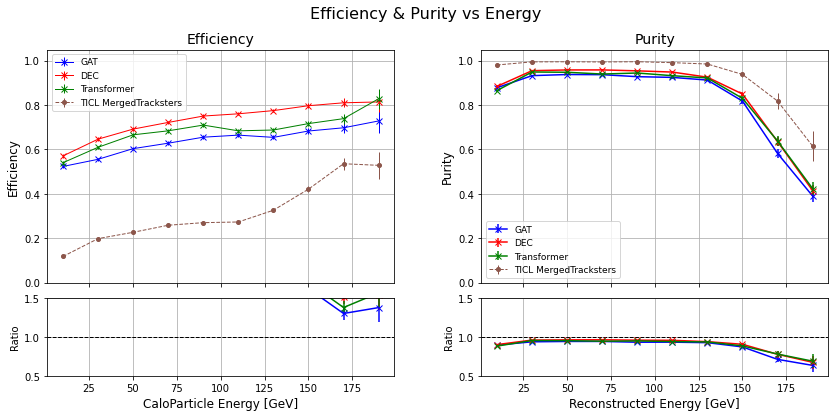

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Load your DataFrames (for Efficiency)
# --------------------------------------------------------------------
# Assume these are already in your workspace:
# df_GAT, df_DE, df_Trans, df_Track, df_MT

# --------------------------------------------------------------------
# 2. Load Electron DataFrames (for Purity)
# --------------------------------------------------------------------

# 3. Prepare data for EFFICIENCY
# --------------------------------------------------------------------
# Build a temporary dictionary with all keys:
model_dfs_all = {
    "GAT": df_GAT,
    "DE": df_DE,  # will be renamed to "DEC"
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,  # unwanted; do not include
    "CERN Mixed Tracksters": df_MT
}

# Cast numeric columns and filter for pgid in [11, -11]
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([11, -11])]

def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Process all curves
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define efficiency binning
all_energies = pd.concat([df['cp_energy'] for df in model_prepared_all.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

for df in model_prepared_all.values():
    df['energy_bin'] = pd.cut(df['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

def aggregate_efficiency(df):
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

# Compute efficiency aggregates
eff_all = {name: aggregate_efficiency(df) for name, df in model_prepared_all.items()}

# Build final dictionary: drop "CERN Tracksters", rename keys.
model_efficiency = {
    "GAT": eff_all["GAT"],
    "DEC": eff_all["DE"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 4. Prepare data for PURITY
# --------------------------------------------------------------------
# Similarly, create a dictionary for electron data.
model_dfs_e_all = {
    'GAT': df_GAT_e,
    'DE': df_DE_e,  # will be renamed to "DEC"
    'Transformer': df_Trans_e,
    'CERN Tracksters': df_Track_e,  # drop this one
    'CERN Mixed Tracksters': df_MT_e
}

def prepare_trackster_data(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

prepared_dfs_e_all = {name: prepare_trackster_data(df) for name, df in model_dfs_e_all.items()}

# Define purity binning
all_energies_e = pd.concat([df['trackster_energy'] for df in prepared_dfs_e_all.values()])
min_energy_e = all_energies_e.min()
max_energy_e = 200
n_bins_e = 10
energy_bins_e = np.linspace(min_energy_e, max_energy_e, n_bins_e + 1)
bin_centers_e = 0.5 * (energy_bins_e[:-1] + energy_bins_e[1:])

for df in prepared_dfs_e_all.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins_e, labels=False, include_lowest=True)

def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg.set_index('energy_bin').reindex(range(n_bins_e)).reset_index()

pur_all = {name: aggregate_purity(df) for name, df in prepared_dfs_e_all.items()}

model_purity = {
    "GAT": pur_all["GAT"],
    "DEC": pur_all["DE"],
    "Transformer": pur_all["Transformer"],
    "TICL MergedTracksters": pur_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 5. Build the figure: 2 columns (Efficiency and Purity) with top and ratio subplots
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# -----------------------
# LEFT COLUMN: Efficiency
# -----------------------
left_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(left_gs[0])
ax_eff_ratio = fig.add_subplot(left_gs[1], sharex=ax_eff)

# Set colors and marker/line styles:
# For "GAT", "DEC", and "Transformer": cross markers ('x'), solid lines, their respective colors.
# For "TICL MergedTracksters": black dashed line with circle markers.
eff_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "tab:brown"
}

for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        color = eff_colors[key]
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        color = eff_colors[key]
        linewidth = 1
        markersize = 6
    ax_eff.errorbar(
        bin_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

# Remove x-axis tick labels from the top plot.
ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency', fontsize=14)

# Efficiency ratio plot (divide each non-reference curve by TICL MergedTracksters)
ref_key_eff = "TICL MergedTracksters"
ref_eff = model_efficiency[ref_key_eff]
ref_eff_val = ref_eff['efficiency'].replace(0, np.nan)
ref_eff_err = ref_eff['eff_error']

for key, agg in model_efficiency.items():
    if key == ref_key_eff:
        continue
    # For ratio curves, use cross markers (for GAT, DEC, Transformer)
    marker_style = "x"
    linestyle = "-"
    color = eff_colors[key]
    ratio = agg['efficiency'] / ref_eff_val
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 + (ref_eff_err/ref_eff_val)**2)
    ax_eff_ratio.errorbar(
        bin_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=color
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)
# No legend for ratios

# ------------------------
# RIGHT COLUMN: Purity
# ------------------------
right_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_purity = fig.add_subplot(right_gs[0])
ax_purity_ratio = fig.add_subplot(right_gs[1], sharex=ax_purity)

pur_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "tab:brown"
}

for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        color = pur_colors[key]
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        color = pur_colors[key]
        linewidth = 1.5
        markersize = 6
    ax_purity.errorbar(
        bin_centers_e, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

# Remove x-axis tick labels from the purity top plot.
ax_purity.tick_params(labelbottom=False)
ax_purity.set_ylabel('Purity', fontsize=12)
ax_purity.set_ylim(0, 1.05)
ax_purity.legend(fontsize=9)
ax_purity.grid(True)
ax_purity.set_title('Purity', fontsize=14)

# Purity ratio (divide each non-reference curve by TICL MergedTracksters)
ref_key_pur = "TICL MergedTracksters"
ref_pur = model_purity[ref_key_pur]
ref_pur_val = ref_pur['purity'].replace(0, np.nan)
ref_pur_err = ref_pur['purity_error']

for key, agg in model_purity.items():
    if key == ref_key_pur:
        continue
    marker_style = "x"
    linestyle = "-"
    color = pur_colors[key]
    ratio = agg['purity'] / ref_pur_val
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 + (ref_pur_err/ref_pur_val)**2)
    ax_purity_ratio.errorbar(
        bin_centers_e, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=color
    )

ax_purity_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_purity_ratio.set_xlabel('Reconstructed Energy [GeV]', fontsize=12)
ax_purity_ratio.set_ylabel('Ratio', fontsize=10)
ax_purity_ratio.set_ylim(0.5, 1.5)
ax_purity_ratio.grid(True)
# No legend for ratios

plt.suptitle('Efficiency & Purity vs Energy', fontsize=16)

plt.show()


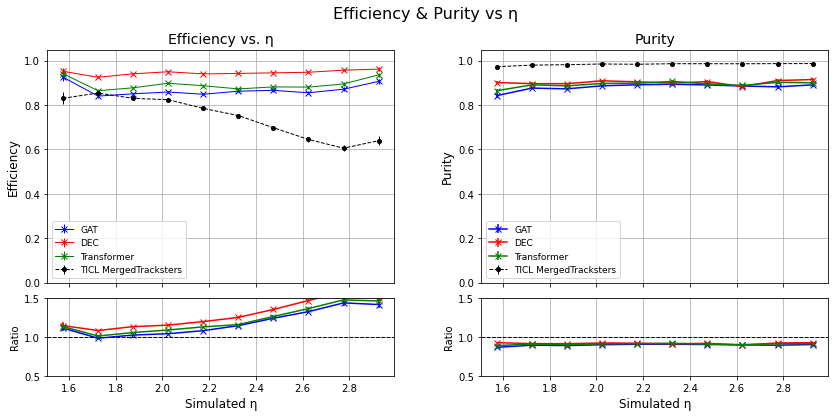

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Load your DataFrames (for Efficiency)
# --------------------------------------------------------------------
# Assume these are already in your workspace:
# df_GAT, df_DE, df_Trans, df_Track, df_MT

# --------------------------------------------------------------------
# 2. Load Electron DataFrames (for Purity)
# --------------------------------------------------------------------
# (Used for purity vs. η, e.g. the trackster files)


# --------------------------------------------------------------------
# 3. Prepare Efficiency vs. η from CaloParticle data
# --------------------------------------------------------------------
# Build a temporary dictionary with all keys.
# We will later drop "CERN Tracksters" and rename "DE" to "DEC" and "CERN Mixed Tracksters" to "TICL MergedTracksters".
model_dfs_all = {
    "GAT": df_GAT,
    "DE": df_DE,  # will be renamed to DEC
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,  # drop this one
    "CERN Mixed Tracksters": df_MT
}

# Cast numeric columns; also cast the cp_eta column.
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([11, -11])]

# Function to prepare CaloParticle data (including η)
def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'cp_eta': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # A CaloParticle is considered reconstructed if its shared_energy is at least 50% of its cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Process all curves.
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define η binning (here from 1.5 to 3.0 in 10 bins; adjust as needed).
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2

# Assign η bins to each DataFrame.
for df in model_prepared_all.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate efficiency versus η.
def aggregate_efficiency_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all = {name: aggregate_efficiency_eta(df) for name, df in model_prepared_all.items()}

# Build final efficiency dictionary: drop "CERN Tracksters" and rename keys.
model_efficiency_eta = {
    "GAT": eff_all["GAT"],
    "DEC": eff_all["DE"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 4b. Prepare Purity vs. η from Electron Trackster data
# --------------------------------------------------------------------
# Build a dictionary from the electron trackster DataFrames.
model_dfs_e_all = {
    "GAT": df_GAT_e,
    "DE": df_DE_e,  # will be renamed to DEC
    "Transformer": df_Trans_e,
    "CERN Tracksters": df_Track_e,  # drop this one
    "CERN Mixed Tracksters": df_MT_e
}

# Assume the electron trackster files provide a measurement of trackster_eta.
def prepare_trackster_data_eta(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')  # make sure your file contains this column
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # For purity, we define "associated" as having a reco_to_sim_score < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Process electron data.
model_prepared_e = {name: prepare_trackster_data_eta(df) for name, df in model_dfs_e_all.items()}

# Use the same η binning as before.
for df in model_prepared_e.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate purity versus η.
def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_eta = {name: aggregate_purity_eta(df) for name, df in model_prepared_e.items()}

model_purity_eta = {
    "GAT": pur_all_eta["GAT"],
    "DEC": pur_all_eta["DE"],
    "Transformer": pur_all_eta["Transformer"],
    "TICL MergedTracksters": pur_all_eta["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 5. Build the Figure: Efficiency and Purity vs. η (side by side)
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
# Create two columns: left for efficiency, right for purity.
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs. η -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# Define colors and marker/line styles for efficiency.
# For "GAT", "DEC", and "Transformer": use cross markers with solid lines.
# For "TICL MergedTracksters": use circle markers with a black dashed line.
eff_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
        color = eff_colors[key]
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1
        markersize = 6
        color = eff_colors[key]
    ax_eff.errorbar(
        eta_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

# Remove x-axis tick labels from the top (efficiency) plot.
ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency vs. η', fontsize=14)

# Efficiency ratio: Divide each non-reference curve by TICL MergedTracksters.
ref_key_eff = "TICL MergedTracksters"
ref_eff = model_efficiency_eta[ref_key_eff]
ref_val_eff = ref_eff['efficiency'].replace(0, np.nan)
ref_err_eff = ref_eff['eff_error']

for key, agg in model_efficiency_eta.items():
    if key == ref_key_eff:
        continue
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    color = eff_colors[key]
    ratio = agg['efficiency'] / ref_val_eff
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 + (ref_err_eff/ref_val_eff)**2)
    ax_eff_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=color
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('Simulated η', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)
# No legend for the ratio plot.

# ----- Right Column: Purity vs. η -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

# Define colors and marker/line styles for purity.
# For "GAT", "DEC", and "Transformer": cross markers with solid lines.
# For "TICL MergedTracksters": circle markers with a black dashed line.
pur_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
        color = pur_colors[key]
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
        color = pur_colors[key]
    ax_pur.errorbar(
        eta_centers, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

# Remove x-axis tick labels from the top purity plot.
ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity', fontsize=14)

# Purity ratio: Divide each non-reference curve by TICL MergedTracksters.
ref_key_pur = "TICL MergedTracksters"
ref_pur = model_purity_eta[ref_key_pur]
ref_val_pur = ref_pur['purity'].replace(0, np.nan)
ref_err_pur = ref_pur['purity_error']

for key, agg in model_purity_eta.items():
    if key == ref_key_pur:
        continue
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    color = pur_colors[key]
    ratio = agg['purity'] / ref_val_pur
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 + (ref_err_pur/ref_val_pur)**2)
    ax_pur_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=color
    )

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('Simulated η', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)
# No legend for the ratio plot.

plt.suptitle('Efficiency & Purity vs η', fontsize=16)
plt.show()


/tmp/ipykernel_2711597/1646984105.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_2711597/1646984105.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_2711597/1646984105.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

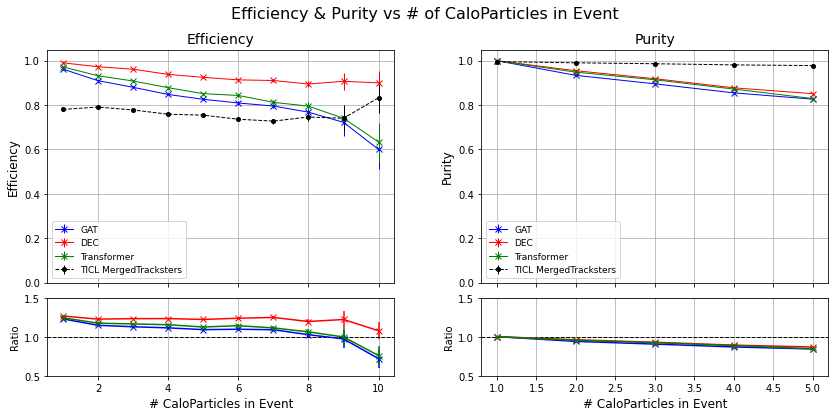

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Load DataFrames (for Efficiency)
# --------------------------------------------------------------------
# e.g. df_GAT, df_DE, df_Trans, df_Track, df_MT

# --------------------------------------------------------------------
# 2. Load DataFrames (for Purity)
# --------------------------------------------------------------------
# e.g. df_GAT_e, df_DE_e, df_Trans_e, df_Track_e, df_MT_e

# --------------------------------------------------------------------
# 3. Prepare Efficiency vs. # of CaloParticles in the event
# --------------------------------------------------------------------
# We'll build a dict with all keys, then drop "CERN Tracksters" and rename "DE" to "DEC",
# "CERN Mixed Tracksters" to "TICL MergedTracksters".

model_dfs_all = {
    "GAT": df_GAT,
    "DE": df_DE,            # rename to "DEC"
    "Transformer": df_Trans,
    "CERN Tracksters": df_Track,  # will drop
    "CERN Mixed Tracksters": df_MT
}

# Cast columns to numeric and filter for pgid in [11, -11].
# Then, for each event, determine the number of unique cp_id's in that event.
for name, df in model_dfs_all.items():
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    # Filter only electrons (pgid = ±11), or pions if you prefer – adjust as needed.
    df = df[df['pgid'].isin([11, -11])]

    # For each row, add a column indicating how many unique cp_id are in that event
    # We use "transform('nunique')" to broadcast the group result back to each row
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')

    # A "mini grouping" to figure out how much shared energy each (event, cp_id) has
    # in order to define whether it's reconstructed
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max',
        'n_cp': 'first'  # get the event's total CP count (the same for all rows in that event)
    }).reset_index()

    # Mark whether this CP was reconstructed
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)

    model_dfs_all[name] = grouped

# Now we have dataframes with columns: event_index, cp_id, cp_energy, shared_energy, n_cp, reco
# We'll define a function to aggregate efficiency vs n_cp
def aggregate_efficiency_ncp(df):
    # Group by 'n_cp', count total CPs and how many are reconstructed
    agg = df.groupby('n_cp').agg(
        total_cp=('cp_id', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    # Binomial error estimate
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

# Compute efficiency aggregates for all curves
eff_all = {name: aggregate_efficiency_ncp(df) for name, df in model_dfs_all.items()}

# Build final dictionary: drop "CERN Tracksters" and rename keys
model_efficiency_ncp = {
    "GAT": eff_all["GAT"],
    "DEC": eff_all["DE"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 4. Prepare Purity vs. # of CaloParticles in the event (from Electron Trackster data)
# --------------------------------------------------------------------
model_dfs_e_all = {
    "GAT": df_GAT_e,
    "DE": df_DE_e,             # rename to "DEC"
    "Transformer": df_Trans_e,
    "CERN Tracksters": df_Track_e,    # drop
    "CERN Mixed Tracksters": df_MT_e
}

def prepare_trackster_data_ncp(df):
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')  # or however your data references CP IDs
    # Filter if needed (e.g. pgid ±11?), depends on how your electron trackster data is structured.

    # For each row, number of unique cp_id in that event
    # (assuming the same event -> same number of CPs as in the efficiency data).
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')

    # Then we group by (event_index, trackster_id) to define "assoc"
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'reco_to_sim_score': 'min',
        'n_cp': 'first'
    }).reset_index()

    # e.g. trackster is "associated" if reco_to_sim_score < 0.2
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_all = {name: prepare_trackster_data_ncp(df) for name, df in model_dfs_e_all.items()}

def aggregate_purity_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_ts=('trackster_id', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all = {name: aggregate_purity_ncp(df) for name, df in model_prepared_e_all.items()}

model_purity_ncp = {
    "GAT": pur_all["GAT"],
    "DEC": pur_all["DE"],
    "Transformer": pur_all["Transformer"],
    "TICL MergedTracksters": pur_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 5. Build the Figure: Efficiency and Purity vs. Number of CaloParticles (side by side)
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs n_cp -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# We want to plot as a function of n_cp (an integer).
# We'll create x-values from the "n_cp" column, sorting to ensure ascending order.
# Then, for each DataFrame, we align the x-values with efficiency.
eff_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, df_agg in model_efficiency_ncp.items():
    df_agg_sorted = df_agg.sort_values('n_cp')  # ensure ascending n_cp
    xvals = df_agg_sorted['n_cp']
    yvals = df_agg_sorted['efficiency']
    yerr  = df_agg_sorted['eff_error']

    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        color = eff_colors[key]
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        color = eff_colors[key]
        lw = 1
        ms = 6

    ax_eff.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=color)

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency', fontsize=14)

# Efficiency Ratio Subplot
ref_key_eff = "TICL MergedTracksters"
ref_df_eff = model_efficiency_ncp[ref_key_eff].sort_values('n_cp')
ref_xvals = ref_df_eff['n_cp']
ref_vals = ref_df_eff['efficiency'].replace(0, np.nan)
ref_errs = ref_df_eff['eff_error']

for key, df_agg in model_efficiency_ncp.items():
    if key == ref_key_eff:
        continue
    df_agg_sorted = df_agg.sort_values('n_cp')
    # We must match x-values so we only ratio at the same n_cp points.
    # Use merge or reindex approach. For simplicity, let's merge on n_cp:
    merged = pd.merge(df_agg_sorted, ref_df_eff, on='n_cp', suffixes=('', '_ref'))

    xvals  = merged['n_cp']
    num_val  = merged['efficiency']
    num_err  = merged['eff_error']
    den_val  = merged['efficiency_ref'].replace(0, np.nan)
    den_err  = merged['eff_error_ref']

    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)

    marker_style = "x"
    ls = "-"
    color = eff_colors[key]
    lw = 1.5
    ms = 6

    ax_eff_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=color)

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ----- Right Column: Purity vs n_cp -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

pur_colors = {
    "GAT": "blue",
    "DEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, df_agg in model_purity_ncp.items():
    df_agg_sorted = df_agg.sort_values('n_cp')
    xvals = df_agg_sorted['n_cp']
    yvals = df_agg_sorted['purity']
    yerr  = df_agg_sorted['purity_error']

    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        color = pur_colors[key]
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        color = pur_colors[key]
        lw = 1
        ms = 6

    ax_pur.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=color)

ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity', fontsize=14)

# Purity Ratio Subplot
ref_key_pur = "TICL MergedTracksters"
ref_df_pur = model_purity_ncp[ref_key_pur].sort_values('n_cp')
ref_xvals_p = ref_df_pur['n_cp']
ref_vals_p = ref_df_pur['purity'].replace(0, np.nan)
ref_errs_p = ref_df_pur['purity_error']

for key, df_agg in model_purity_ncp.items():
    if key == ref_key_pur:
        continue
    df_agg_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_agg_sorted, ref_df_pur, on='n_cp', suffixes=('', '_ref'))

    xvals  = merged['n_cp']
    num_val  = merged['purity']
    num_err  = merged['purity_error']
    den_val  = merged['purity_ref'].replace(0, np.nan)
    den_err  = merged['purity_error_ref']

    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)

    marker_style = "x"
    ls = "-"
    color = pur_colors[key]
    lw = 1.5
    ms = 6

    ax_pur_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=color)

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs # of CaloParticles in Event', fontsize=16)
plt.show()
